In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import joblib
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from xgboost import XGBClassifier
from gensim.models import Word2Vec

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('vader_lexicon')
# Import NLTK English stopwords
stop_words = set(stopwords.words('english'))

# Define lemmatization function
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    # Convert POS tag to WordNet format
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # Lemmatize tokens
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    # Return lemmatized tokens as a list
    return lemmas

# Custom preprocessing function
def preprocessing(text):
    # Convert text to lowercase
    lower_text = text.lower()

    # Remove punctuation
    punctuation_free = "".join([char for char in lower_text if char not in string.punctuation])

    # Remove URLs
    remove_urls = re.sub(r'http\S+', '', punctuation_free)

    # Remove digits
    remove_digits = re.sub(r'\d', '', remove_urls)

    # Tokenize text
    tokenized_text = word_tokenize(remove_digits)

    # Remove stop words
    filtered_tokens = [token for token in tokenized_text if token not in stop_words]

    # Lemmatize tokens
    lemmatized_tokens = lemmatize_tokens(filtered_tokens)

    return lemmatized_tokens  # Return tokenized and lemmatized tokens

# Load data
X_augmented = joblib.load('/content/drive/My Drive/Master_Thesis/X_augmented.pkl')
y_augmented = joblib.load('/content/drive/My Drive/Master_Thesis/y_augmented.pkl')
X_train = joblib.load('/content/drive/My Drive/Master_Thesis/X_train.pkl')
y_train = joblib.load('/content/drive/My Drive/Master_Thesis/y_train.pkl')
X_test = joblib.load('/content/drive/My Drive/Master_Thesis/X_test.pkl')
y_test = joblib.load('/content/drive/My Drive/Master_Thesis/y_test.pkl')

# Concatenate X_train and X_augmented
X_combined = pd.concat([X_train, pd.Series(X_augmented)], ignore_index=True)

# Combine y_train and y_augmented
y_combined = np.concatenate([y_train, np.array(y_augmented)])

# Ensure y_combined is a numpy array
if not isinstance(y_combined, np.ndarray):
    raise TypeError("y_combined is not a numpy array.")

# Shuffle X_combined and y_combined together
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

# Check the first few rows of X_combined
print("First few rows of X_combined:")
print(X_combined.head())

# Ensure X_combined is a Series
if not isinstance(X_combined, pd.Series):
    raise TypeError("X_combined is not a Series.")

# Define TF-IDF Vectorizer pipeline
tfidf_data_augmented = Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer=lambda text: preprocessing(text),  # Custom preprocessing function
        stop_words='english',        # Remove English stopwords
        ngram_range=(1, 1)           # Consider only unigrams
    ))
])

# Fit and transform the combined data
X_combined_tfidf = tfidf_data_augmented.fit_transform(X_combined)
X_test_tfidf = tfidf_data_augmented.transform(X_test)

# Train Word2Vec model with tokenized sentences
tokenized_combined = [preprocessing(post) for post in X_combined]
tokenized_test = [preprocessing(post) for post in X_test]
word2vec_model = Word2Vec(sentences=tokenized_combined)

# Function to obtain Word2Vec embedding for a sentence
def get_word2vec_embedding(model, tokens, size=100,sg=1):
    vec = np.zeros(size)
    count = 0
    for token in tokens:
        if token in model.wv:
            vec += model.wv[token]
            count += 1
    if count != 0:
        vec /= count
    return vec

# Obtain Word2Vec embeddings for each post
X_train_word2vec = np.array([get_word2vec_embedding(word2vec_model, post) for post in tokenized_combined])
X_test_word2vec = np.array([get_word2vec_embedding(word2vec_model, post) for post in tokenized_test])

# VADER Sentiment Analysis
sia = SentimentIntensityAnalyzer()
X_train_vader = np.array([list(sia.polarity_scores(' '.join(doc)).values()) for doc in tokenized_combined])
X_test_vader = np.array([list(sia.polarity_scores(' '.join(doc)).values()) for doc in tokenized_test])

# Combine features
# Concatenate the feature vectors
X_train_combined = np.concatenate((X_combined_tfidf.toarray(), X_train_word2vec, X_train_vader), axis=1)
X_test_combined = np.concatenate((X_test_tfidf.toarray(), X_test_word2vec, X_test_vader), axis=1)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


First few rows of X_combined:
150      i am sorry, but the text "jessicafilan it is" ...
6887     i had a rough day today. it felt like everythi...
13077    i just can't shake this feeling of dread that ...
9513     i feel overwhelmed and torn between two confli...
9666     i find myself in the same boat every night, dr...
dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make', 'u'] not in stop_words.
  warnings.warn(


In [ ]:
# Check the shapes of TF-IDF matrices
print("Number of features in X_combined_tfidf:", X_combined_tfidf.shape[1])
print("Number of features in X_test_tfidf:", X_test_tfidf.shape[1])

# Compute sample weights for handling class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_combined)

# Define the best parameters for XGBClassifier
best_xgb_params = {
    'n_estimators': 120,
    'min_child_weight': 1,
    'max_depth': 5,
    'learning_rate': 0.23,
    'lambda': 0.04,
    'gamma': 0.7,
    'alpha': 0.1
}

# Create XGBClassifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(**best_xgb_params)

# Fit the model with the transformed training data
best_xgb_classifier.fit(X_train_combined, y_combined, sample_weight=sample_weights)

# Make predictions on the test data
y_pred = best_xgb_classifier.predict(X_test_combined)

# Print the classification report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)
"""
Number of features in X_combined_tfidf: 11246
Number of features in X_test_tfidf: 11246

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       780
           1       0.71      0.71      0.71       252
           2       0.77      0.67      0.72       279
           3       0.66      0.69      0.67       236

    accuracy                           0.83      1547
   macro avg       0.77      0.76      0.76      1547
weighted avg       0.83      0.83      0.83      1547
"""


Number of features in X_combined_tfidf: 11246
Number of features in X_test_tfidf: 11246
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       780
           1       0.73      0.73      0.73       252
           2       0.76      0.68      0.72       279
           3       0.64      0.66      0.65       236

    accuracy                           0.83      1547
   macro avg       0.77      0.76      0.76      1547
weighted avg       0.83      0.83      0.83      1547



'\nNumber of features in X_combined_tfidf: 11246\nNumber of features in X_test_tfidf: 11246\n\n              precision    recall  f1-score   support\n\n           0       0.93      0.97      0.95       780\n           1       0.71      0.71      0.71       252\n           2       0.77      0.67      0.72       279\n           3       0.66      0.69      0.67       236\n\n    accuracy                           0.83      1547\n   macro avg       0.77      0.76      0.76      1547\nweighted avg       0.83      0.83      0.83      1547\n'

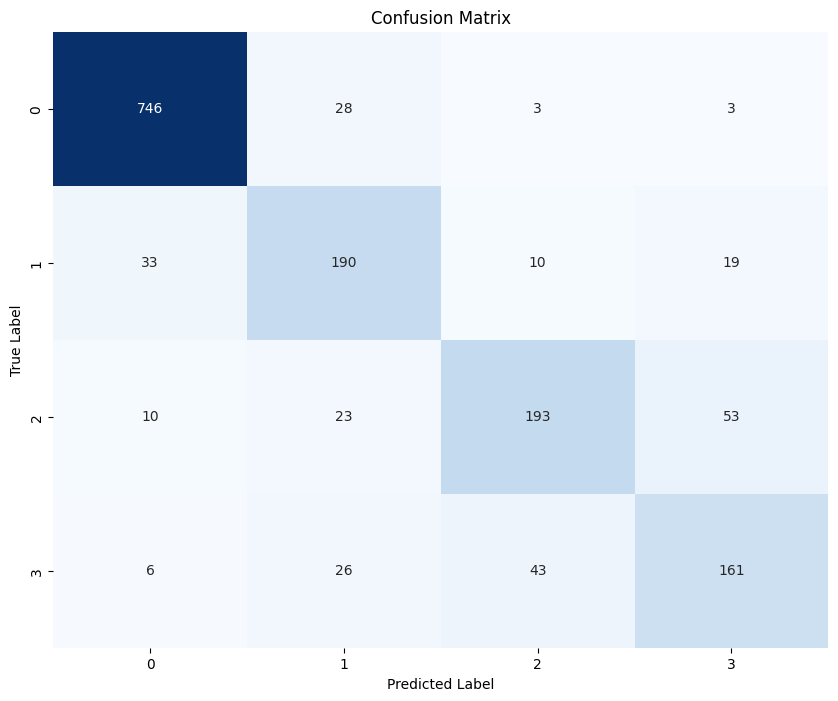

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
#plt.savefig('/content/drive/My Drive/Master_Thesis/confusion matrix XGBoost.png')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Assuming best_xgb_classifier is defined and trained
# Plot learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    best_xgb_classifier, X_train_combined, y_combined,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1_weighted', cv=10, shuffle=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Print final F1 scores for training and validation
final_train_f1_mean = train_scores_mean[-1]
final_valid_f1_mean = valid_scores_mean[-1]

plt.figure(figsize=(10, 6))
plt.title('Learning Curve of Best Params:n_estimators:120, min_child_weight:1, max_depth:5, learning_rate:0.23, lambda:0.04, gamma:0.7, alpha:0.1')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="orange")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="blue")
plt.plot(train_sizes, train_scores_mean, 'o-', color="orange", label="Training Score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="blue", label="Validation Score")
# Add annotations for the final F1 scores
plt.annotate(f'{final_train_f1_mean:.4f}',
             xy=(train_sizes[-1], final_train_f1_mean),
             xytext=(train_sizes[-1], final_train_f1_mean- 0.03),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=8, color='orange', ha='center')

plt.annotate(f'{final_valid_f1_mean:.4f}',
             xy=(train_sizes[-1], final_valid_f1_mean),
             xytext=(train_sizes[-1], final_valid_f1_mean- 0.03),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=8, color='blue', ha='center')

plt.legend(loc="best")
plt.grid()
#plt.savefig('/content/drive/My Drive/Master_Thesis/learning_curve_best_params_XGBoost.png')  # Save the plot with filename based on class number

plt.show()